<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v11_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA CV FER

Objective
 - EWC only for the self.feature_extractor and self.class_classifier block
 - Based on V9 (which is based on v8)
  - Used race dataset as validation dataloader (ds_expw_crop_image_race => EXPWIMAGECROPRACE, DatasetEXPWIMAGECROPRACE)
  - used Squeeze and Excite on basic pretrained models to check accuracy - https://www.robots.ox.ac.uk/~albanie/pytorch-models.html - VGG vgg_vd_face_sfew (weights)
  - Attention in FC layers leads to degredation, however in FC layer it helps
  - LR reduction currently 0.2, can make it 0.5 ??
  - Increase early stop by few more epochs based on no change in best value ??
  - multiple SE blocks
  - Non DANN
    - SFEW VAL:  Average loss: 0.1103, Accuracy: 232/419 (55.37%)
    - RACE DS:
  - DANN
    - SFEW VAL: Average loss: 0.1102, Accuracy: 239/419 (57.04%)
    - RACE DS: Average loss: 0.1975, Accuracy: 2436/8458 (28.80%)

  - EWC DANN (GPU Crashed)
    - SFEW VAL:
    - RACE DS:

Observations
  - Attention in FC layers leads to degredation, however in FC layer it helps
  - Non DANN
    - SFEW VAL:  
    - RACE DS:
  - DANN
    - SFEW VAL:
    - RACE DS:

  - EWC DANN
    - SFEW VAL:
    - RACE DS:


Models
  - 23_05


## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

In [1]:
# !pip install --upgrade Pillow

### Cloning Repo, Installing dependencies

In [2]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 544, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 544 (delta 29), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (544/544), 45.69 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [3]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [4]:
# Generic Libraries
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd

In [5]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE
from da_cv_fer.utils import *
from da_cv_fer.run_config import RunConfig

### Initializing Configs

In [6]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [7]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating Dataloader

In [8]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.

### Example Images

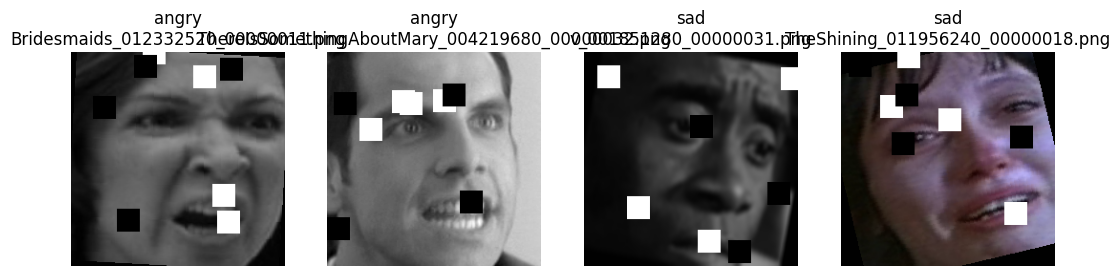

In [9]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [10]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Performance Metrics

In [11]:
#TODO: Move to Utils

labels_map={0:"Angry",
            1:"Disgust",
            2:"Fear",
            3:"Happy",
            4:"Sad",
            5:"Surprise",
            6:"Neutral"}

def performance_metric(model,
                       device,
                       data_loader):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images*255)) # forward pass, output = {class}
          true_labels.extend(labels.argmax(dim=1).cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())
    # print(f'true labels - {true_labels}')
    # print(f'predicted labels - {predicted_labels}')

    true_labels = [labels_map[int_label] for int_label in true_labels]
    predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_names = list(labels_map.values())
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report



## Model Initialization

### Model_V11_SE
- including dann
- including grl
- including SE - muliple places, after maxpool


In [12]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [13]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [14]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [15]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        # self.se_block = SEBlock(512)
        list_feature_extractor.insert(-15,  SEBlock(256))
        list_feature_extractor.insert(-8,  SEBlock(512))
        list_feature_extractor.insert(-1,  SEBlock(512))
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [16]:
model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)
from torchsummary import summary  #for model summary and params
print(model)

DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [18]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [19]:
# !pip install torch-summary

In [20]:
# from torchsummary import summary
# summary(model, (3, 224, 224), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose =2 )

## Checking accuracy before fine tuning

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [22]:
model = model.to(device=device)

### Test Function

In [23]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [24]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

#### Pre fine train metric

In [25]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.1216, Accuracy: 109/419 (26.01%)



(109, 0.12155070168306265)

In [26]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.26014319809069214
Precision: 0.2893514782319956
Confusion Matrix:
[[26 11  5  5 11 15  2]
 [ 2  5  1  5  2  6  1]
 [11  3  4  3  7 15  0]
 [ 1  5  1 41 10 14  0]
 [ 5  5  9  2  6 19  6]
 [ 0  9  7  4 37 26  1]
 [ 4  4 10  1  2 49  1]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        26       11     5      5   11        15        2
Disgust       2        5     1      5    2         6        1
Fear         11        3     4      3    7        15        0
Happy         1        5     1     41   10        14        0
Sad           5        5     9      2    6        19        6
Surprise      0        9     7      4   37        26        1
Neutral       4        4    10      1    2        49        1
Classification Report:
              precision    recall  f1-score   support

       Angry       0.53      0.35      0.42        75
     Disgust       0.12      0.23      0.16        22
        Fear       0.11      0.09      0.10        43
       Happy     

### Train Function

#### Basic Training Function

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()
    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs,_,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset: .2f} %')

    return



#### Training Function with LR Scheduler

In [28]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Execution without Learning Rate

In [30]:
# num_epochs=55
# for epoch in range(num_epochs):
#   train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
#   test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')
# print('Training finished.')

### Execution with LR

In [34]:
runconfig = RunConfig()
device = runconfig.device

model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)
best_model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)

#learning rate
lr =  0.001 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 2 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 15 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 150


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  150
epoch = 1...in training function


Loss=0.8592650294303894 Accuracy=571/913(62.54%) Epoch Avg loss=0.06640528 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  5.99it/s]


Test / Val: Average loss: 0.0992, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 0
Updated the best model with correct: 186



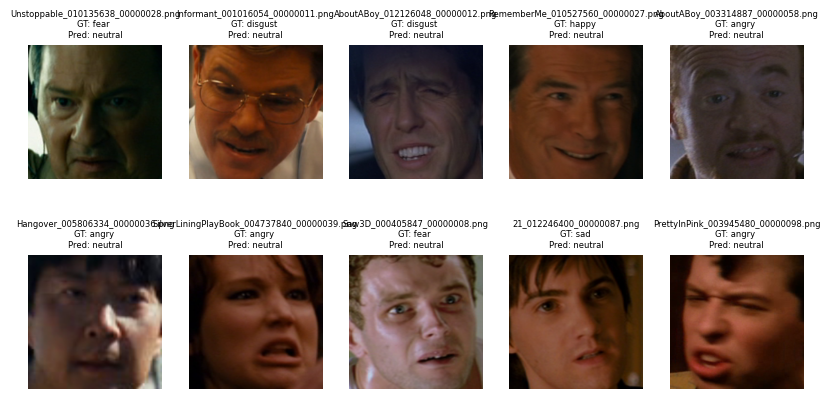

EPOCH: 2  of  150
epoch = 2...in training function


Loss=1.265974998474121 Accuracy=578/913(63.31%) Epoch Avg loss=0.06448579 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.00it/s]


Test / Val: Average loss: 0.0981, Accuracy: 220/419 (52.51%)

last correct =220 | best correct = 186
Updated the best model with correct: 220

EPOCH: 3  of  150
epoch = 3...in training function


Loss=0.0013450870756059885 Accuracy=617/913(67.58%) Epoch Avg loss=0.05954875 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


Test / Val: Average loss: 0.1177, Accuracy: 185/419 (44.15%)

last correct =185 | best correct = 220
EPOCH: 4  of  150
epoch = 4...in training function


Loss=0.000756216119043529 Accuracy=670/913(73.38%) Epoch Avg loss=0.04879462 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1292, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 220
EPOCH: 5  of  150
epoch = 5...in training function


Loss=2.525055170059204 Accuracy=666/913(72.95%) Epoch Avg loss=0.05430970 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1031, Accuracy: 192/419 (45.82%)

last correct =192 | best correct = 220
EPOCH: 6  of  150
epoch = 6...in training function


Loss=6.129754066467285 Accuracy=693/913(75.90%) Epoch Avg loss=0.05088861 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1223, Accuracy: 150/419 (35.80%)

last correct =150 | best correct = 220
EPOCH: 7  of  150
epoch = 7...in training function


Loss=0.8050566911697388 Accuracy=481/913(52.68%) Epoch Avg loss=0.08241082 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1467, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 220
EPOCH: 8  of  150
epoch = 8...in training function


Loss=1.1101585626602173 Accuracy=599/913(65.61%) Epoch Avg loss=0.06401275 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1091, Accuracy: 182/419 (43.44%)

last correct =182 | best correct = 220
EPOCH: 9  of  150
epoch = 9...in training function


Loss=1.300105094909668 Accuracy=659/913(72.18%) Epoch Avg loss=0.05289604 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1163, Accuracy: 204/419 (48.69%)

last correct =204 | best correct = 220
EPOCH: 10  of  150
epoch = 10...in training function


Loss=1.9610049724578857 Accuracy=652/913(71.41%) Epoch Avg loss=0.05321936 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1385, Accuracy: 182/419 (43.44%)

last correct =182 | best correct = 220
EPOCH: 11  of  150
epoch = 11...in training function


Loss=0.014842323027551174 Accuracy=643/913(70.43%) Epoch Avg loss=0.05684731 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.03it/s]


Test / Val: Average loss: 0.1107, Accuracy: 190/419 (45.35%)

last correct =190 | best correct = 220


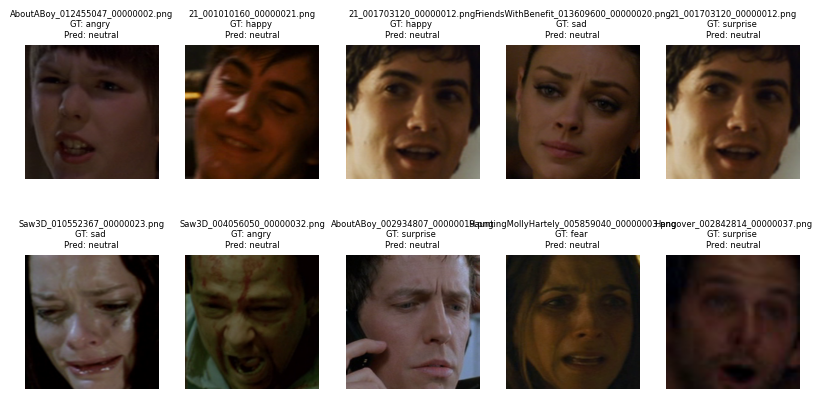

EPOCH: 12  of  150
epoch = 12...in training function


Loss=5.912699222564697 Accuracy=740/913(81.05%) Epoch Avg loss=0.04380102 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1093, Accuracy: 216/419 (51.55%)

last correct =216 | best correct = 220
EPOCH: 13  of  150
epoch = 13...in training function


Loss=0.11860423535108566 Accuracy=707/913(77.44%) Epoch Avg loss=0.04461162 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1061, Accuracy: 212/419 (50.60%)

last correct =212 | best correct = 220
EPOCH: 14  of  150
epoch = 14...in training function


Loss=1.4872758388519287 Accuracy=747/913(81.82%) Epoch Avg loss=0.03482839 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1214, Accuracy: 205/419 (48.93%)

last correct =205 | best correct = 220
EPOCH: 15  of  150
epoch = 15...in training function


Loss=0.0003323002893012017 Accuracy=747/913(81.82%) Epoch Avg loss=0.03389323 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1151, Accuracy: 220/419 (52.51%)

last correct =220 | best correct = 220
EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.003644967917352915 Accuracy=789/913(86.42%) Epoch Avg loss=0.02704205 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


Test / Val: Average loss: 0.1157, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 220
Updated the best model with correct: 222

EPOCH: 17  of  150
epoch = 17...in training function


Loss=1.3106491565704346 Accuracy=807/913(88.39%) Epoch Avg loss=0.02538723 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1170, Accuracy: 215/419 (51.31%)

last correct =215 | best correct = 222
EPOCH: 18  of  150
epoch = 18...in training function


Loss=0.0977998748421669 Accuracy=780/913(85.43%) Epoch Avg loss=0.02582005 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1159, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 222
EPOCH: 19  of  150
epoch = 19...in training function


Loss=0.008174297399818897 Accuracy=812/913(88.94%) Epoch Avg loss=0.02246264 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1374, Accuracy: 225/419 (53.70%)

last correct =225 | best correct = 222
Updated the best model with correct: 225

EPOCH: 20  of  150
epoch = 20...in training function


Loss=0.7418623566627502 Accuracy=821/913(89.92%) Epoch Avg loss=0.02013322 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1277, Accuracy: 224/419 (53.46%)

last correct =224 | best correct = 225
EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.005482636857777834 Accuracy=834/913(91.35%) Epoch Avg loss=0.01789550 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1325, Accuracy: 226/419 (53.94%)

last correct =226 | best correct = 225
Updated the best model with correct: 226



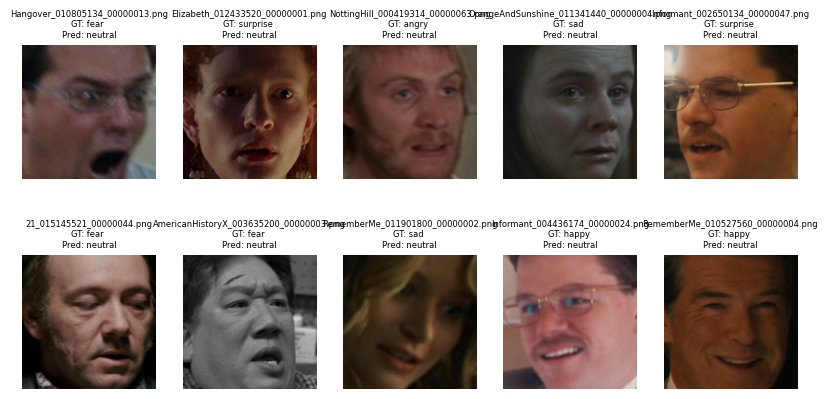

EPOCH: 22  of  150
epoch = 22...in training function


Loss=1.1920928244535389e-07 Accuracy=835/913(91.46%) Epoch Avg loss=0.01617609 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1284, Accuracy: 226/419 (53.94%)

last correct =226 | best correct = 226
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.14856106042861938 Accuracy=839/913(91.89%) Epoch Avg loss=0.01536777 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1337, Accuracy: 232/419 (55.37%)

last correct =232 | best correct = 226
Updated the best model with correct: 232

EPOCH: 24  of  150
epoch = 24...in training function


Loss=1.0728830375228426e-06 Accuracy=855/913(93.65%) Epoch Avg loss=0.01361406 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1419, Accuracy: 232/419 (55.37%)

last correct =232 | best correct = 232
EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.00012814177898690104 Accuracy=835/913(91.46%) Epoch Avg loss=0.01672989 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1286, Accuracy: 235/419 (56.09%)

last correct =235 | best correct = 232
Updated the best model with correct: 235

EPOCH: 26  of  150
epoch = 26...in training function


Loss=0.00019977481861133128 Accuracy=850/913(93.10%) Epoch Avg loss=0.01335862 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1571, Accuracy: 226/419 (53.94%)

last correct =226 | best correct = 235
EPOCH: 27  of  150
epoch = 27...in training function


Loss=0.0010130041046068072 Accuracy=849/913(92.99%) Epoch Avg loss=0.01386017 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1343, Accuracy: 224/419 (53.46%)

last correct =224 | best correct = 235
-------Early Stopping at epoch 27---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1303, Accuracy: 235/419 (56.09%)



In [35]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model_local(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)


dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


### Validation on Test Dataset - only when data loader is avaialable



In [36]:
# test_model_local(model= best_model,
#                             device= device,
#                             data_loader = data_loader['target']['val'], # target val loader
#                             class_loss_function = runconfig.criterion_class)

### `Model Performance Metrics`

In [37]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.5608591885441527
Precision: 0.5420003398788535
Confusion Matrix:
[[46  1  1  5  9 10  3]
 [ 3  3  1  3  2  6  4]
 [13  1  6  3 10  6  4]
 [ 1  0  0 65  1  4  1]
 [ 6  1  4  4 30  5  2]
 [ 4  1  3  7  8 52  9]
 [ 2  2  4  7 14  9 33]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        46        1     1      5    9        10        3
Disgust       3        3     1      3    2         6        4
Fear         13        1     6      3   10         6        4
Happy         1        0     0     65    1         4        1
Sad           6        1     4      4   30         5        2
Surprise      4        1     3      7    8        52        9
Neutral       2        2     4      7   14         9       33
Classification Report:
              precision    recall  f1-score   support

       Angry       0.61      0.61      0.61        75
     Disgust       0.33      0.14      0.19        22
        Fear       0.32      0.14      0.19        43
       Happy      

### Saving Non-Dann Model

In [38]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [39]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
print("\nDO VERIFY THE MODEL NAME BEFORE MOVING AHEAD: ", model_name)


DO VERIFY THE MODEL NAME BEFORE MOVING AHEAD:  non_dann_sfew_expw_23_05_se.pt


In [40]:
# model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_{se}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [41]:
model_name

'non_dann_sfew_expw_23_05_se.pt'

## Dataset - Target

- EXPW dataset

In [42]:
# checking the mounted drive and mounting if not done
import os
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")


Google Drive is already mounted.


### Creating Dataloader for EXPW

In [43]:
from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE
from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE


expw_obj = EXPWIMAGECROPRACE(type = None, crop_at_runtime=False)

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds created successfully.
Dataset URL: https://www.kaggle.com/datasets/mohammedaaltaha/expwds


100%|██████████| 7.68G/7.68G [01:22<00:00, 99.7MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
train list [('astound_expression_549.jpg', 6), ('amazed_girl_351.jpg', 6)] <class 'list'> 1000
size of dataset (list_img_label): 1000
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
26 were not able to crop
974 cropped images created in cropped
---NOT CROPPING AT RUNTIME --
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_d

In [44]:
# {0:"Angry",
#             1:"Disgust",
#             2:"Fear",
#             3:"Happy",
#             4:"Sad",
#             5:"Surprise",
#             6:"Neutral"}

# ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

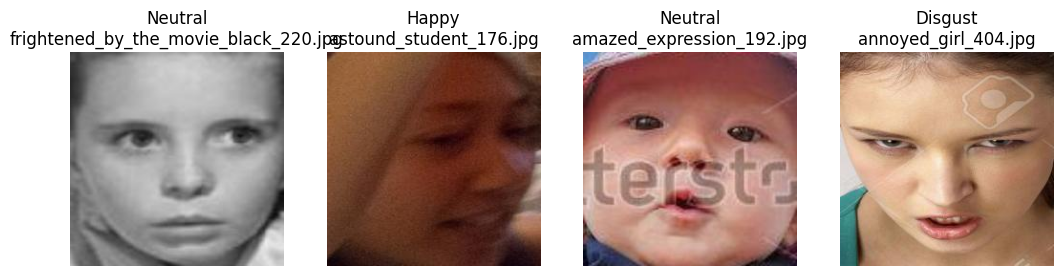

In [45]:
show_batch(expw_train_loader,["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"],4, normalized = False)

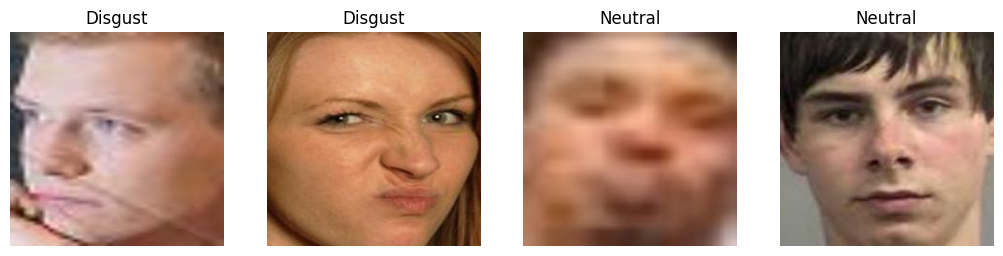

In [46]:
show_batch(expw_val_loader,["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"],4, normalized = False)

In [47]:
if expw_train_loader is None:
  sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
  data_loader = {'source' : sfew_loader}
  source_name = data_loader['source']['name']
  target_name = "expw"
else:
  sfew_loader = {'name': 'sfew',
                'train':sfew_train_loader,
                'val':sfew_val_loader
                }

  expw_loader = {'name': 'expw',
                'train':expw_train_loader,
                'val':expw_val_loader
                }

  data_loader = {'source' : sfew_loader,
                'target' : expw_loader}

  source_name = data_loader['source']['name']
  target_name = data_loader['target']['name']

### Validation of non dann on Test Dataset - only when data loader is avaialable


In [49]:
test_model_local(model= best_model,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = runconfig.criterion_class)

Test / Val: Average loss: 0.3238, Accuracy: 2598/8458 (30.72%)



(2598, 0.3238010995916284)

## Loading NON DANN Model for DANN and DANN EWC


In [50]:
# source_name = "sfew"
# target_name = "expw"
today_model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
print(f'today_model_name {today_model_name}')
custom_model_name= 'non_dann_sfew_expw_08_04.pt'
print(f'custom_model_name {custom_model_name}')

model_name = today_model_name

print("\n****model name that would be used for loading: ", model_name)

today_model_name non_dann_sfew_expw_23_05_se.pt
custom_model_name non_dann_sfew_expw_08_04.pt

****model name that would be used for loading:  non_dann_sfew_expw_23_05_se.pt


### Loading Structure of Models

In [51]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        # self.se_block = SEBlock(512)
        list_feature_extractor.insert(-15,  SEBlock(256))
        list_feature_extractor.insert(-8,  SEBlock(512))
        list_feature_extractor.insert(-1,  SEBlock(512))
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features



In [52]:
if not device:
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

In [53]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

model_dann =  DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

model_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

model_dann_ewc = deepcopy(model_dann) # saves training time - check with all

# print(model_dann)

In [54]:
model_dann

DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

In [55]:
params = {name: param for name, param in model_dann.named_parameters() if param.requires_grad}
params.keys()

dict_keys(['feature_extractor.0.weight', 'feature_extractor.0.bias', 'feature_extractor.2.weight', 'feature_extractor.2.bias', 'feature_extractor.5.weight', 'feature_extractor.5.bias', 'feature_extractor.7.weight', 'feature_extractor.7.bias', 'feature_extractor.10.weight', 'feature_extractor.10.bias', 'feature_extractor.12.weight', 'feature_extractor.12.bias', 'feature_extractor.14.weight', 'feature_extractor.14.bias', 'feature_extractor.17.fc.0.weight', 'feature_extractor.17.fc.0.bias', 'feature_extractor.17.fc.2.weight', 'feature_extractor.17.fc.2.bias', 'feature_extractor.18.weight', 'feature_extractor.18.bias', 'feature_extractor.20.weight', 'feature_extractor.20.bias', 'feature_extractor.22.weight', 'feature_extractor.22.bias', 'feature_extractor.25.fc.0.weight', 'feature_extractor.25.fc.0.bias', 'feature_extractor.25.fc.2.weight', 'feature_extractor.25.fc.2.bias', 'feature_extractor.26.weight', 'feature_extractor.26.bias', 'feature_extractor.28.weight', 'feature_extractor.28.bias

## Test Function

In [56]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

## DANN Execution: Training, Validating, Saving

### DANN Execution Function

In [57]:
def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [58]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
lr_dann = 0.001 # override
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)



EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### DANN Execution

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch[1/150] Step[1/58]: loss_total=1.5108 / domain_loss_target=0.6814 / domain_loss_source=0.7257 / task_loss=0.1036 / domain_loss=0.8294 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[11/58]: loss_total=1.6061 / domain_loss_target=0.5998 / domain_loss_source=0.7580 / task_loss=0.2484 / domain_loss=1.0064 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[21/58]: loss_total=1.6205 / domain_loss_target=0.5191 / domain_loss_source=0.7422 / task_loss=0.3592 / domain_loss=1.1014 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[31/58]: loss_total=1.8920 / domain_loss_target=0.6237 / domain_loss_source=0.6702 / task_loss=0.5980 / domain_loss=1.2683 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[41/58]: loss_total=2.0313 / domain_loss_target=0.6050 / domain_loss_source=0.7580 / task_loss=0.6682 / domain_loss=1.4263 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[51/58]: loss_total=2.2252 / domain_loss_target

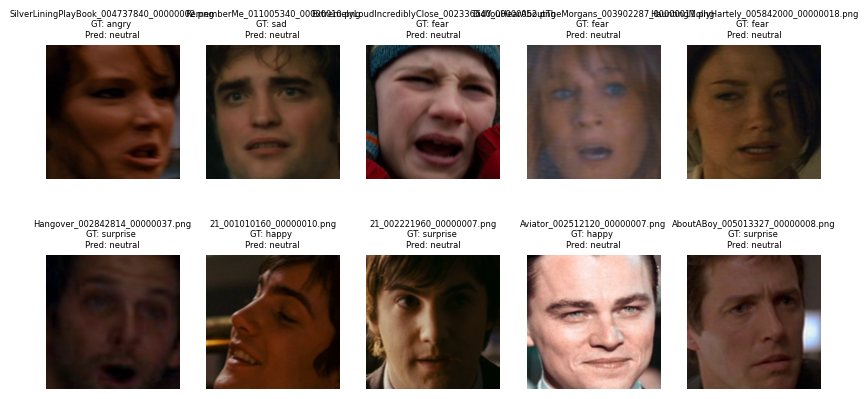

epoch = 2...in DANN execution function
Epoch[2/150] Step[1/58]: loss_total=1.9657 / domain_loss_target=0.6180 / domain_loss_source=0.7773 / task_loss=0.5704 / domain_loss=1.3477 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[11/58]: loss_total=1.6925 / domain_loss_target=0.6238 / domain_loss_source=0.6931 / task_loss=0.3756 / domain_loss=1.0687 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[21/58]: loss_total=1.8370 / domain_loss_target=0.6901 / domain_loss_source=0.6731 / task_loss=0.4739 / domain_loss=1.1470 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[31/58]: loss_total=1.8302 / domain_loss_target=0.6694 / domain_loss_source=0.7143 / task_loss=0.4465 / domain_loss=1.1608 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[41/58]: loss_total=2.0115 / domain_loss_target=0.6362 / domain_loss_source=0.7280 / task_loss=0.6473 / domain_loss=1.3753 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[51/58]: loss_total=1.5380 / domain_loss_target=0.6151 / domain_loss_source=0.7552 / task_loss=0.1677 / domain

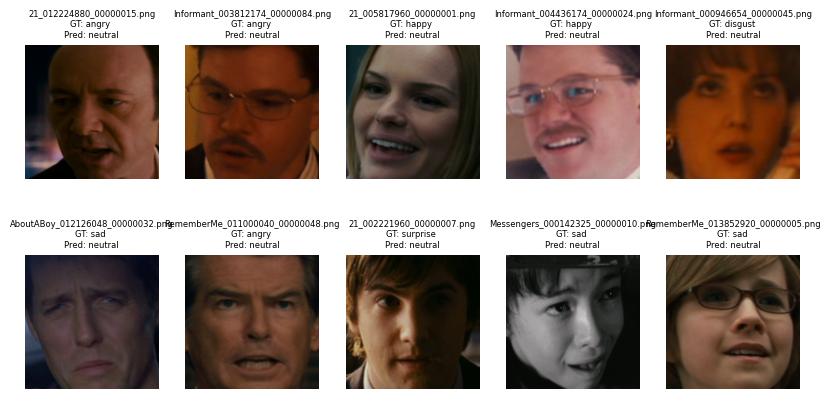

epoch = 12...in DANN execution function
Epoch[12/150] Step[1/58]: loss_total=1.7026 / domain_loss_target=0.6790 / domain_loss_source=0.6844 / task_loss=0.3392 / domain_loss=1.0236 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[11/58]: loss_total=1.5154 / domain_loss_target=0.6604 / domain_loss_source=0.7267 / task_loss=0.1283 / domain_loss=0.8550 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[21/58]: loss_total=1.6744 / domain_loss_target=0.6878 / domain_loss_source=0.6336 / task_loss=0.3529 / domain_loss=0.9865 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[31/58]: loss_total=1.6659 / domain_loss_target=0.6684 / domain_loss_source=0.6947 / task_loss=0.3029 / domain_loss=0.9976 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[41/58]: loss_total=1.6824 / domain_loss_target=0.7456 / domain_loss_source=0.7000 / task_loss=0.2368 / domain_loss=0.9368 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[51/58]: loss_total=1.3901 / domain_loss_target=0.7250 / domain_loss_source=0.6443 / task_loss=0.0209 /

In [59]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

### DANN Saving

In [60]:
dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(dann_model_trained.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_sfew_expw_23_05_se.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_23_05_se.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_23_05_se.pt!


### DANN Performance

In [61]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


Accuracy: 0.548926014319809
Precision: 0.5341146857162433
Confusion Matrix:
[[48  6  1  1  9  7  3]
 [ 4  1  0  2  2  9  4]
 [15  4  6  2  5  6  5]
 [ 3  0  0 60  0  6  3]
 [ 8  2  2  3 29  7  1]
 [ 5  1  3  4  8 58  5]
 [ 5  0  3  4 12 19 28]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        48        6     1      1    9         7        3
Disgust       4        1     0      2    2         9        4
Fear         15        4     6      2    5         6        5
Happy         3        0     0     60    0         6        3
Sad           8        2     2      3   29         7        1
Surprise      5        1     3      4    8        58        5
Neutral       5        0     3      4   12        19       28
Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.64      0.59        75
     Disgust       0.07      0.05      0.06        22
        Fear       0.40      0.14      0.21        43
       Happy       

In [ ]:
#@title Inferencing on Test Dataset
test_model_local(model= dann_model_trained,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = runconfig.criterion_class)

## EWC DANN Execution: Training, Validating, Saving


In [62]:
model_dann_ewc


DANN_VGG_SE(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): SEBlock(

### EWC Code
- Regularization Penalty

In [63]:
from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        # for n, p in deepcopy(self.params).items():
        for n, p in self.params.items():

            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            batch[0] = batch[0]* 255.0
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = self.model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execution Function

In [64]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(existing_model.to(device),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)


            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx +1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    # print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses



### EWC DANN Execution Config

In [65]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
lr_ewc_dann = 0.001 #override

optimizer_ewc_dann = optim.SGD(model_dann_ewc.parameters(), lr = lr_ewc_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override
# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)


EPOCHS 150
0.4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### EWC DANN Execution

In [66]:
print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model= model_dann_ewc,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = scheduler,
                                                          early_stop_patience = early_stop_patience,
                                                          early_stop_difference = early_stop_difference
                                                         )

------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/150] Step [1/58]: loss_total=1.8396 / domain_loss_target=0.6643 / domain_loss_source=0.7011 / task_loss=0.4742 / domain_loss=1.1753 / alpha=1.0000 / lr=0.001000
Epoch [1/150] Step [51/58]: loss_total=1.8652 / domain_loss_target=0.5625 / domain_loss_source=0.7435 / task_loss=0.5591 / domain_loss=1.3027 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss: 0.1284, Accuracy: 200/419 (47.73%)

last correct =200 | best correct = 0
Updated the best model with correct: 200

epoch = 2...in EWC DANN execution function
Epoch [2/150] Step [1/58]: loss_total=1.6094 / domain_loss_target=0.5732 / domain_loss_source=0.7213 / task_loss=0.3149 / domain_loss=1.0362 / alpha=1.0000 / lr=0.001000
Epoch [2/150] Step [51/58]: loss_total=2.2575 / domain_loss_target=0.7231 / domain_loss_source=0.6838 / task_loss=0.8505 / domain_loss=1.5344 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss

### EWC DANN Saving

In [67]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_se.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))



if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')

ewc_dann_sfew_expw_23_05_se.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_23_05_se.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_23_05_se.pt!


### EWC DANN Performance

In [68]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= ewc_dann_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.5441527446300716
Precision: 0.5228262317665551
Confusion Matrix:
[[52  2  3  3  4  7  4]
 [ 7  2  1  4  1  5  2]
 [ 9  1 10  4 10  4  5]
 [ 2  0  0 62  4  1  3]
 [14  0  6  3 20  6  3]
 [ 6  2  4  5  6 50 11]
 [ 2  1  6  7 12 11 32]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        52        2     3      3    4         7        4
Disgust       7        2     1      4    1         5        2
Fear          9        1    10      4   10         4        5
Happy         2        0     0     62    4         1        3
Sad          14        0     6      3   20         6        3
Surprise      6        2     4      5    6        50       11
Neutral       2        1     6      7   12        11       32
Classification Report:
              precision    recall  f1-score   support

       Angry       0.57      0.69      0.62        75
     Disgust       0.25      0.09      0.13        22
        Fear       0.33      0.23      0.27        43
       Happy      

In [ ]:
#@title Inferencing on Test Dataset
test_model_local(model= ewc_dann_model,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = runconfig.criterion_class)

# Inference

## Loading Models

In [108]:
non_dann_model_inference = best_model
dann_model_sfew_expw_inference = dann_model_trained
ewc_dann_model_sfew_expw_inference = ewc_dann_model

In [109]:
labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

In [110]:
#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print(prediction.shape, labels.shape)
    # print(prediction)
    # print(prediction.argmax(dim=1))
    # print(labels)
    # print(labels.argmax(dim=1))
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

def test_model_race(model, device, test_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model((data*255))
            # print("class output",class_output.shape)
            # print("target ",target.shape)
            class_loss = class_loss_function(class_output, target)  # sum up batch loss
            test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].argmax(dim=-1).item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=-1)[i].item())]}
                # print(result_row)
                result.loc[len(result)] = result_row
                # result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

# def test_model_local(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output,_,_  = model((images*255)) # forward pass, output = {class}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_preds(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#         100. * correct / len(data_loader.dataset)))


#     return correct, test_loss

## Inferencing

In [111]:
non_dann_correct, non_dann_test_loss, non_dann_accuracy, non_dann_result = test_model_race(model = non_dann_model_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

Test / Val: Average loss: 0.3238, Accuracy: 2598/8458 (30.72%)



In [112]:
non_dann_result

,image,gt_emotion,gt_race,p_emotion
0,boring_wife_160.jpg,Happy,White,Happy
1,disgust_boss_613.jpg,Neutral,African,Angry
2,fighting_expression_46.jpg,Neutral,White,Angry
3,mad_teacher_282.jpg,Fear,White,Fear
4,angry_son_343.jpg,Neutral,White,Surprise
...,...,...,...,...
8453,amazed_girl_217.jpg,Happy,White,Disgust
8454,hostile_mother_182.jpg,Neutral,White,Happy
8455,fierce_manager_193.jpg,Neutral,White,Happy
8456,fierce_husband_455.jpg,Neutral,Indian,Happy


In [113]:

# Create the pivot table
pivot_table = pd.pivot_table(non_dann_result, index='gt_emotion', columns='gt_race', aggfunc='size', fill_value=0)
print("\nPivot Table:")
print(pivot_table)


Pivot Table:
gt_race     African  Asian  Indian  Latino  Middle Eastern  White
gt_emotion                                                       
Angry            27     37      21       3               7    249
Disgust          42     52      22       0               8    258
Fear              7      9       3       0               1     74
Happy           243    346     157     115              51   1879
Neutral         367    407     285      13              80   2026
Sad              93    158      64      38              38    625
Surprise         35     63      28      25              17    485


In [114]:
dann_correct, dann_test_loss, dann_accuracy, dann_result = test_model_race(model = dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

Test / Val: Average loss: 0.2679, Accuracy: 2432/8458 (28.75%)



In [115]:
dann_result

,image,gt_emotion,gt_race,p_emotion
0,heartbroken_father_128.jpg,Neutral,Asian,Sad
1,astound_actor_497.jpg,Neutral,African,Fear
2,crying_chinese_723.jpg,Sad,Asian,Sad
3,crying_girl_1.jpg,Sad,White,Neutral
4,heartbroken_expression_362.jpg,Neutral,White,Fear
...,...,...,...,...
8453,astound_son_774.jpg,Neutral,White,Happy
8454,angry_lady_52.jpg,Angry,White,Angry
8455,amazed_student_651.jpg,Happy,White,Happy
8456,astound_expression_342.jpg,Happy,White,Sad


In [116]:
ewc_dann_correct, ewc_dann_test_loss, ewc_dann_accuracy, ewc_dann_result = test_model_race(model = ewc_dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

Test / Val: Average loss: 0.3283, Accuracy: 2365/8458 (27.96%)



In [117]:
ewc_dann_result


,image,gt_emotion,gt_race,p_emotion
0,awe_infant_349.jpg,Neutral,White,Surprise
1,amazed_manager_488.jpg,Neutral,White,Fear
2,amazed_people_162.jpg,Neutral,Asian,Surprise
3,awe_student_297.jpg,Happy,White,Happy
4,amazed_family_153.jpg,Happy,White,Angry
...,...,...,...,...
8453,angry_european_452.jpg,Neutral,White,Fear
8454,awe_lady_248.jpg,Neutral,Asian,Neutral
8455,astound_expression_224.jpg,Happy,White,Sad
8456,amazed_asian_72.jpg,Happy,Asian,Happy


## Saving the output

In [118]:
non_dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_{str(time.strftime("%d_%m"))}.csv')
dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_{str(time.strftime("%d_%m"))}.csv')
ewc_dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_{str(time.strftime("%d_%m"))}.csv')

In [119]:
# reading the output

non_dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_{str(time.strftime("%d_%m"))}.csv')
dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_{str(time.strftime("%d_%m"))}.csv')
ewc_dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_{str(time.strftime("%d_%m"))}.csv')

In [120]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,boring_wife_160.jpg,Happy,White,Happy
1,1,disgust_boss_613.jpg,Neutral,African,Angry
2,2,fighting_expression_46.jpg,Neutral,White,Angry
3,3,mad_teacher_282.jpg,Fear,White,Fear
4,4,angry_son_343.jpg,Neutral,White,Surprise
...,...,...,...,...,...
8453,8453,amazed_girl_217.jpg,Happy,White,Disgust
8454,8454,hostile_mother_182.jpg,Neutral,White,Happy
8455,8455,fierce_manager_193.jpg,Neutral,White,Happy
8456,8456,fierce_husband_455.jpg,Neutral,Indian,Happy


In [121]:
dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,heartbroken_father_128.jpg,Neutral,Asian,Sad
1,1,astound_actor_497.jpg,Neutral,African,Fear
2,2,crying_chinese_723.jpg,Sad,Asian,Sad
3,3,crying_girl_1.jpg,Sad,White,Neutral
4,4,heartbroken_expression_362.jpg,Neutral,White,Fear
...,...,...,...,...,...
8453,8453,astound_son_774.jpg,Neutral,White,Happy
8454,8454,angry_lady_52.jpg,Angry,White,Angry
8455,8455,amazed_student_651.jpg,Happy,White,Happy
8456,8456,astound_expression_342.jpg,Happy,White,Sad


In [122]:
ewc_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,awe_infant_349.jpg,Neutral,White,Surprise
1,1,amazed_manager_488.jpg,Neutral,White,Fear
2,2,amazed_people_162.jpg,Neutral,Asian,Surprise
3,3,awe_student_297.jpg,Happy,White,Happy
4,4,amazed_family_153.jpg,Happy,White,Angry
...,...,...,...,...,...
8453,8453,angry_european_452.jpg,Neutral,White,Fear
8454,8454,awe_lady_248.jpg,Neutral,Asian,Neutral
8455,8455,astound_expression_224.jpg,Happy,White,Sad
8456,8456,amazed_asian_72.jpg,Happy,Asian,Happy


## Demographic Parity

In [123]:
df = non_dann_result

In [124]:
pivot_race_gt_emotion = pd.pivot_table(df, index='gt_race', columns='gt_emotion', aggfunc='size', fill_value=0)
pivot_race_gt_emotion

gt_emotion,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
gt_race,,,,,,,
African,27,42,7,243,367,93,35
Asian,37,52,9,346,407,158,63
Indian,21,22,3,157,285,64,28
Latino,3,0,0,115,13,38,25
Middle Eastern,7,8,1,51,80,38,17
White,249,258,74,1879,2026,625,485


In [125]:
pivot_race_p_emotion = pd.pivot_table(df, index='gt_race', columns='p_emotion', aggfunc='size', fill_value=0)
pivot_race_p_emotion

p_emotion,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
gt_race,,,,,,,
African,120,75,69,280,80,74,116
Asian,88,94,60,406,75,141,208
Indian,70,73,37,183,37,92,88
Latino,20,18,6,100,14,10,26
Middle Eastern,38,14,6,49,14,42,39
White,721,716,275,1971,434,644,835


In [126]:
df_race_gt_emotion = pivot_race_gt_emotion.reset_index()
df_race_gt_emotion

gt_emotion,gt_race,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
0,African,27,42,7,243,367,93,35
1,Asian,37,52,9,346,407,158,63
2,Indian,21,22,3,157,285,64,28
3,Latino,3,0,0,115,13,38,25
4,Middle Eastern,7,8,1,51,80,38,17
5,White,249,258,74,1879,2026,625,485


### Race Emotion Distribution

In [127]:
def get_race_emotion_distribution (df:pd.DataFrame) -> dict:
  race_emotion_distribution = {} # {race:{emotion:count}}

  for index, row in df.iterrows():
    emotion_distribution ={} # {emotion:count}
    # for emotion in df.columns[1:]:
    for emotion in ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] :
      try:
        emotion_distribution[emotion] = row[emotion]
      except:
        emotion_distribution[emotion] = 0

    race_emotion_distribution[row[df.columns[0]]] = emotion_distribution

  return race_emotion_distribution

In [128]:
ground_truth_race_emotion_distribution = get_race_emotion_distribution(df_race_gt_emotion)
ground_truth_race_emotion_distribution

{'African': {'Angry': 27,
  'Disgust': 42,
  'Fear': 7,
  'Happy': 243,
  'Neutral': 367,
  'Sad': 93,
  'Surprise': 35},
 'Asian': {'Angry': 37,
  'Disgust': 52,
  'Fear': 9,
  'Happy': 346,
  'Neutral': 407,
  'Sad': 158,
  'Surprise': 63},
 'Indian': {'Angry': 21,
  'Disgust': 22,
  'Fear': 3,
  'Happy': 157,
  'Neutral': 285,
  'Sad': 64,
  'Surprise': 28},
 'Latino': {'Angry': 3,
  'Disgust': 0,
  'Fear': 0,
  'Happy': 115,
  'Neutral': 13,
  'Sad': 38,
  'Surprise': 25},
 'Middle Eastern': {'Angry': 7,
  'Disgust': 8,
  'Fear': 1,
  'Happy': 51,
  'Neutral': 80,
  'Sad': 38,
  'Surprise': 17},
 'White': {'Angry': 249,
  'Disgust': 258,
  'Fear': 74,
  'Happy': 1879,
  'Neutral': 2026,
  'Sad': 625,
  'Surprise': 485}}

In [129]:
ground_truth_race_emotion_distribution.keys()

dict_keys(['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'])

In [130]:
predicted_race_emotion_distribution = get_race_emotion_distribution(pivot_race_p_emotion.reset_index() )
predicted_race_emotion_distribution

{'African': {'Angry': 120,
  'Disgust': 75,
  'Fear': 69,
  'Happy': 280,
  'Neutral': 80,
  'Sad': 74,
  'Surprise': 116},
 'Asian': {'Angry': 88,
  'Disgust': 94,
  'Fear': 60,
  'Happy': 406,
  'Neutral': 75,
  'Sad': 141,
  'Surprise': 208},
 'Indian': {'Angry': 70,
  'Disgust': 73,
  'Fear': 37,
  'Happy': 183,
  'Neutral': 37,
  'Sad': 92,
  'Surprise': 88},
 'Latino': {'Angry': 20,
  'Disgust': 18,
  'Fear': 6,
  'Happy': 100,
  'Neutral': 14,
  'Sad': 10,
  'Surprise': 26},
 'Middle Eastern': {'Angry': 38,
  'Disgust': 14,
  'Fear': 6,
  'Happy': 49,
  'Neutral': 14,
  'Sad': 42,
  'Surprise': 39},
 'White': {'Angry': 721,
  'Disgust': 716,
  'Fear': 275,
  'Happy': 1971,
  'Neutral': 434,
  'Sad': 644,
  'Surprise': 835}}

## Chi-Square (Statistical) test

In [131]:
# Function to perform Chi-Square test for each demographic group
import numpy as np
from scipy.stats import chi2
def chi_square_test(expected_counts, predicted_counts,
                    demographic_groups = ['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'],
                    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'], alpha=0.05):
    results = {}

    for group in demographic_groups:
        expected = np.array(list(expected_counts[group].values()))
        predicted = np.array(list(predicted_counts[group].values()))

        # Calculate the Chi-Square statistic
        chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)

        # Degrees of freedom
        degrees_of_freedom = len(emotions) - 1

        # Critical value for the significance level
        critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

        # P-Value
        p_value = chi2.sf(chi_square_statistic, degrees_of_freedom)

        # Store the results
        results[group] = {
            'Chi-Square Statistic': chi_square_statistic,
            'Critical Value': critical_value,
            'P-Value': p_value,
            'Significant': chi_square_statistic > critical_value
        }

    return results


In [132]:
results = chi_square_test(ground_truth_race_emotion_distribution, predicted_race_emotion_distribution )

<ipython-input-131-df8a33d6e450>:14: RuntimeWarning: divide by zero encountered in divide
  chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)


In [133]:
# Print the results
for group, result in results.items():
    print(f"Demographic Group: {group}")
    print(f"  Chi-Square Statistic: {result['Chi-Square Statistic']:.4f}")
    print(f"  Critical Value (0.05 significance level): {result['Critical Value']:.4f}")
    print(f"  P-Value: {result['P-Value']:.4f}")
    if result['Significant']:
        print("  Result: Significant difference between predicted and expected distributions.")
    else:
        print("  Result: No significant difference between predicted and expected distributions.")
    print()

Demographic Group: African
  Chi-Square Statistic: 1316.8161
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Asian
  Chi-Square Statistic: 1010.0049
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Indian
  Chi-Square Statistic: 978.8246
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Latino
  Chi-Square Statistic: inf
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Middle Eastern
  Chi-Square Statistic: 250.2058
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant differen

## Disparate Impact

Function to calculate accuracy for each race


In [134]:
#@title Function to calculate accuracy for each race
def calculate_accuracy_per_race(df):
    accuracies = {}
    for race, group in df.groupby('gt_race'):
      # print (race)
      correct_predictions = (group['gt_emotion'] == group['p_emotion']).sum()

      total_predictions = group.shape[0]
      accuracy = correct_predictions / total_predictions
      # print(f' correct_predictions:{correct_predictions}, total_predictions: {total_predictions}, accuracy : {accuracy}')
      accuracies[race] = accuracy
    return accuracies
  # print(group['Angry'])

In [135]:
accuracies_per_race_non_dann  = calculate_accuracy_per_race(non_dann_result)
accuracies_per_race_non_dann

{'African': 0.3034398034398034,
 'Asian': 0.30130597014925375,
 'Indian': 0.24655172413793103,
 'Latino': 0.4742268041237113,
 'Middle Eastern': 0.22772277227722773,
 'White': 0.3121872766261615}

In [136]:
max_accuracy_non_dann = max(accuracies_per_race_non_dann.values())
disparate_impact_ratios_non_dann = {race: (accuracy) / max_accuracy_non_dann for race, accuracy in accuracies_per_race_non_dann.items()}
disparate_impact_ratios_non_dann

{'African': 0.6398621942100203,
 'Asian': 0.6353625892277742,
 'Indian': 0.5199025487256372,
 'Latino': 1.0,
 'Middle Eastern': 0.48019801980198024,
 'White': 0.6583079528856015}

In [137]:
accuracies_per_race_dann  = calculate_accuracy_per_race(dann_result)
print(accuracies_per_race_dann)
max_accuracy_dann = max(accuracies_per_race_dann.values())
print(max_accuracy_dann)
disparate_impact_ratios_dann = {race: (accuracy) / max_accuracy_dann for race, accuracy in accuracies_per_race_dann.items()}
print(disparate_impact_ratios_dann)

{'African': 0.2665847665847666, 'Asian': 0.2789179104477612, 'Indian': 0.23275862068965517, 'Latino': 0.4639175257731959, 'Middle Eastern': 0.2079207920792079, 'White': 0.294674767691208}
0.4639175257731959
{'African': 0.5746382746382747, 'Asian': 0.6012230514096186, 'Indian': 0.5017241379310344, 'Latino': 1.0, 'Middle Eastern': 0.44818481848184816, 'White': 0.635187832578826}


In [138]:
accuracies_per_race_ewc_dann  = calculate_accuracy_per_race(ewc_dann_result)
print(accuracies_per_race_ewc_dann)
max_accuracy_ewc_dann = max(accuracies_per_race_ewc_dann.values())
print(max_accuracy_ewc_dann)
disparate_impact_ratios_ewc_dann = {race: (accuracy) / max_accuracy_ewc_dann for race, accuracy in accuracies_per_race_ewc_dann.items()}
print(disparate_impact_ratios_ewc_dann)

{'African': 0.25184275184275184, 'Asian': 0.2630597014925373, 'Indian': 0.22413793103448276, 'Latino': 0.4536082474226804, 'Middle Eastern': 0.20297029702970298, 'White': 0.28931379556826303}
0.4536082474226804
{'African': 0.5551987938351575, 'Asian': 0.5799270691994572, 'Indian': 0.49412225705329155, 'Latino': 1.0, 'Middle Eastern': 0.4474572457245725, 'White': 0.6378054129573072}


In [139]:
dicts = [disparate_impact_ratios_non_dann, disparate_impact_ratios_dann, disparate_impact_ratios_ewc_dann]
labels = ['non_dann', 'dann', 'dann_ewc']
df_disparate_impact = pd.DataFrame(dicts, index=labels)
df_disparate_impact

,African,Asian,Indian,Latino,Middle Eastern,White
non_dann,0.639862,0.635363,0.519903,1.0,0.480198,0.658308
dann,0.574638,0.601223,0.501724,1.0,0.448185,0.635188
dann_ewc,0.555199,0.579927,0.494122,1.0,0.447457,0.637805



## Equalized Odds


In [140]:
from sklearn.metrics import confusion_matrix

def calculate_tpr_fpr_per_race(df):

    # float_formatter = ":.2f".format
    # np.set_printoptions() #(formatter={'float_kind':})
    race_groups = df.groupby('gt_race')
    tpr_fpr = {}
    for race, group in race_groups:
        cm = confusion_matrix(group['gt_emotion'], group['p_emotion'], labels=emotions)
        # print(race)
        # print(cm)
        tp = cm.diagonal()
        # print(f'tp : {tp}')
        fn = cm.sum(axis=1) - tp
        # print(f'fn : {fn}')
        fp = cm.sum(axis=0) - tp
        tn = cm.sum() - (tp + fn + fp)

        tpr = tp / (tp + fn)
        tpr = np.nan_to_num(tpr)

        fpr = fp / (fp + tn)
        fpr = np.nan_to_num(fpr)

        tpr_diff_fpr = tpr - fpr
        tpr_diff_fpr = np.abs(tpr_diff_fpr)



        # print(f'Positive Rate = {tpr} for race: {race}')
        # print(f'tpr : {tpr}')

        # print(f'fpr : {fpr}')
        # fpr = fp / (fp + tn)
        tpr_fpr[race] = {'TPR': np.round(tpr,2), 'FPR': np.round(fpr,2), "TRP-FPR": np.round(tpr_diff_fpr,2)}
    return tpr_fpr

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# tpr_fpr_per_race = calculate_tpr_fpr_per_race(non_dann_result)
# tpr_fpr_per_race


In [141]:
tpr_fpr_per_race_non_dann = calculate_tpr_fpr_per_race(non_dann_result)
tpr_fpr_per_race_dann = calculate_tpr_fpr_per_race(dann_result)
tpr_fpr_per_race_ewc_dann = calculate_tpr_fpr_per_race(ewc_dann_result)

<ipython-input-140-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-140-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-140-cc022a1ea5da>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)


In [142]:
tpr_fpr_per_race_non_dann

{'African': {'TPR': array([0.56, 0.12, 0.  , 0.71, 0.03, 0.03, 0.14]),
  'FPR': array([0.13, 0.09, 0.09, 0.19, 0.1 , 0.15, 0.06]),
  'TRP-FPR': array([0.42, 0.03, 0.09, 0.52, 0.07, 0.12, 0.07])},
 'Asian': {'TPR': array([0.43, 0.06, 0.33, 0.71, 0.06, 0.13, 0.09]),
  'FPR': array([0.07, 0.09, 0.05, 0.22, 0.14, 0.2 , 0.06]),
  'TRP-FPR': array([0.36, 0.03, 0.28, 0.49, 0.09, 0.07, 0.04])},
 'Indian': {'TPR': array([0.48, 0.23, 0.  , 0.65, 0.11, 0.04, 0.06]),
  'FPR': array([0.11, 0.12, 0.06, 0.19, 0.16, 0.16, 0.06]),
  'TRP-FPR': array([0.37, 0.11, 0.06, 0.46, 0.06, 0.12, 0.  ])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.75, 0.05, 0.04, 0.08]),
  'FPR': array([0.09, 0.09, 0.03, 0.18, 0.05, 0.15, 0.07]),
  'TRP-FPR': array([0.57, 0.09, 0.03, 0.57, 0.  , 0.11, 0.01])},
 'Middle Eastern': {'TPR': array([0.43, 0.  , 0.  , 0.61, 0.18, 0.12, 0.04]),
  'FPR': array([0.18, 0.07, 0.03, 0.12, 0.21, 0.2 , 0.09]),
  'TRP-FPR': array([0.25, 0.07, 0.03, 0.49, 0.03, 0.08, 0.05])},
 'White': {'TPR':

In [143]:
tpr_fpr_per_race_dann

{'African': {'TPR': array([0.63, 0.05, 0.  , 0.58, 0.1 , 0.03, 0.13]),
  'FPR': array([0.25, 0.04, 0.05, 0.09, 0.2 , 0.12, 0.09]),
  'TRP-FPR': array([0.38, 0.01, 0.05, 0.49, 0.1 , 0.09, 0.04])},
 'Asian': {'TPR': array([0.54, 0.02, 0.33, 0.58, 0.15, 0.14, 0.11]),
  'FPR': array([0.14, 0.03, 0.03, 0.14, 0.24, 0.2 , 0.06]),
  'TRP-FPR': array([0.4 , 0.01, 0.3 , 0.43, 0.09, 0.05, 0.04])},
 'Indian': {'TPR': array([0.62, 0.09, 0.33, 0.49, 0.22, 0.07, 0.09]),
  'FPR': array([0.2 , 0.05, 0.05, 0.11, 0.29, 0.12, 0.07]),
  'TRP-FPR': array([0.42, 0.04, 0.29, 0.38, 0.07, 0.04, 0.02])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.69, 0.18, 0.08, 0.  ]),
  'FPR': array([0.14, 0.04, 0.05, 0.16, 0.1 , 0.13, 0.06]),
  'TRP-FPR': array([0.53, 0.04, 0.05, 0.52, 0.08, 0.05, 0.06])},
 'Middle Eastern': {'TPR': array([0.57, 0.  , 0.  , 0.41, 0.24, 0.  , 0.1 ]),
  'FPR': array([0.29, 0.03, 0.02, 0.05, 0.35, 0.1 , 0.07]),
  'TRP-FPR': array([0.28, 0.03, 0.02, 0.36, 0.12, 0.1 , 0.03])},
 'White': {'TPR':

In [144]:
tpr_fpr_per_race_ewc_dann

{'African': {'TPR': array([0.74, 0.  , 0.29, 0.58, 0.05, 0.06, 0.09]),
  'FPR': array([0.23, 0.  , 0.17, 0.11, 0.12, 0.17, 0.04]),
  'TRP-FPR': array([0.51, 0.  , 0.12, 0.47, 0.06, 0.11, 0.06])},
 'Asian': {'TPR': array([0.54, 0.  , 0.33, 0.61, 0.07, 0.13, 0.07]),
  'FPR': array([0.11, 0.01, 0.1 , 0.14, 0.13, 0.31, 0.05]),
  'TRP-FPR': array([0.43, 0.01, 0.24, 0.47, 0.06, 0.18, 0.02])},
 'Indian': {'TPR': array([0.48, 0.  , 0.67, 0.63, 0.11, 0.14, 0.03]),
  'FPR': array([0.2 , 0.02, 0.11, 0.13, 0.18, 0.2 , 0.03]),
  'TRP-FPR': array([0.28, 0.02, 0.56, 0.5 , 0.07, 0.06, 0.01])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.69, 0.08, 0.16, 0.  ]),
  'FPR': array([0.14, 0.01, 0.06, 0.2 , 0.03, 0.22, 0.04]),
  'TRP-FPR': array([0.53, 0.01, 0.06, 0.48, 0.05, 0.06, 0.04])},
 'Middle Eastern': {'TPR': array([0.57, 0.  , 0.  , 0.53, 0.13, 0.06, 0.05]),
  'FPR': array([0.23, 0.02, 0.05, 0.08, 0.22, 0.25, 0.06]),
  'TRP-FPR': array([0.34, 0.02, 0.05, 0.45, 0.09, 0.2 , 0.01])},
 'White': {'TPR':